In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from collections import Counter
import itertools
import seaborn as sn

pd.set_option('display.max_colwidth', 180)
pd.set_option('expand_frame_repr', False)

In [2]:
csvfile = '../proc_data_phase0/verification/all_responses_round0-3_verified_new.csv'
df = pd.read_csv(csvfile, 
    sep="\t")

total_objects=len(df)
print("Total objects: ", total_objects)
df.columns

Total objects:  25315


Index(['vg_image_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0',
       'opt-outs', 'vg_domain', 'top_response_domain_r0',
       'responses_domains_r0', 'url', 'sample_type', 'responses_domains_r1',
       'responses_r1', 'top_response_domain_r1', 'responses_domains_r2',
       'responses_r2', 'top_response_domain_r2', 'responses_domains_r3',
       'responses_r3', 'top_response_domain_r3', 'vg_object_id',
       'all_responses', 'clean', 'canon', 'spellchecked', 'spellchecked_min2',
       'adequacy_mean', 'inadequacy_type', 'same_object', 'vg_adequacy_mean',
       'vg_inadequacy_type', 'vg_same_object'],
      dtype='object')

In [3]:
df

,vg_image_id,cat,synset,vg_obj_name,responses_r0,opt-outs,vg_domain,top_response_domain_r0,responses_domains_r0,url,...,clean,canon,spellchecked,spellchecked_min2,adequacy_mean,inadequacy_type,same_object,vg_adequacy_mean,vg_inadequacy_type,vg_same_object
0,2357077,person,athlete.n.01,batter,"{'man': 4, 'batter': 2, 'baseball player': 1, 'player': 1, 'person': 1}",{},people,people,"{'people': 0.889, '$baseball player': 0.111}",http://object-naming-amore.upf.edu//2357077_815223_singleton_obj.png,...,"Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2})","{'man': 1.0, 'person': 1.0, 'helmet': 0.5, 'baseball player': 1.0, 'player': 1.0, 'batter': 1.0}","{'man': {nan: 1.0}, 'person': {nan: 1.0}, 'helmet': {'bounding box': 1.0}, 'baseball player': {nan: 1.0}, 'player': {nan: 1.0}, 'batter': {nan: 1.0}}","{'man': {'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'helmet': 0.0, 'baseball player': 1.0}, 'person': {'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'h...",1.00,{nan: 1.0},"{'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'helmet': 0.0, 'baseball player': 1.0}"
1,2378759,article of clothing,overgarment.n.01,jacket,"{'jacket': 3, 'sweatshirt': 2, 'man': 2, 'hoodie': 1, 'person': 1}",{},clothing,clothing,"{'clothing': 0.333, '$sweatshirt': 0.222, 'people': 0.333, '$hoodie': 0.111}",http://object-naming-amore.upf.edu//2378759_1365136_supercat_unique.png,...,"Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2})","{'man': 0.5, 'person': 0.5, 'sweatshirt': 1.0, 'jacket': 1.0, 'hoodie': 1.0}","{'man': {'bounding box': 1.0}, 'person': {'bounding box': 1.0}, 'sweatshirt': {nan: 1.0}, 'jacket': {nan: 1.0}, 'hoodie': {nan: 1.0}}","{'man': {'hoodie': 0.0, 'man': 1.0, 'sweatshirt': 0.0, 'person': 1.0, 'jacket': 0.0}, 'person': {'hoodie': 0.0, 'man': 1.0, 'sweatshirt': 0.0, 'person': 1.0, 'jacket': 0.0}, 's...",1.00,{nan: 1.0},"{'hoodie': 1.0, 'man': 0.0, 'sweatshirt': 1.0, 'person': 0.0, 'jacket': 1.0}"
2,2319953,animal,ungulate.n.01,giraffe,{'giraffe': 7},{'#bbox': 2},animals_plants,animals_plants,{'animals_plants': 1.0},http://object-naming-amore.upf.edu//2319953_3089834_singleton_obj.png,...,"Counter({'giraffe': 32, 'woman': 1})","Counter({'giraffe': 32, 'woman': 1})","Counter({'giraffe': 32, 'woman': 1})",Counter({'giraffe': 32}),{'giraffe': 1.0},{'giraffe': {nan: 1.0}},{'giraffe': {'giraffe': 1.0}},1.00,{nan: 1.0},{'giraffe': 1.0}
3,2361401,animal,ungulate.n.01,giraffe,{'giraffe': 9},{},animals_plants,animals_plants,{'animals_plants': 1.0},http://object-naming-amore.upf.edu//2361401_2363103_singleton_obj.png,...,Counter({'giraffe': 36}),Counter({'giraffe': 36}),Counter({'giraffe': 36}),Counter({'giraffe': 36}),{'giraffe': 1.0},{'giraffe': {nan: 1.0}},{'giraffe': {'giraffe': 1.0}},1.00,{nan: 1.0},{'giraffe': 1.0}
4,2401994,"food, nutrient",dish.n.02,sandwich,"{'sandwich': 6, 'food': 2, 'hotdog': 1}",{},food,food,"{'food': 0.889, '$hotdog': 0.111}",http://object-naming-amore.upf.edu//2401994_1141828_singleton_obj.png,...,"Counter({'sandwich': 25, 'food': 6, 'hotdog': 1, 'sandwhich': 1, 'foot': 1, 'cake': 1, 'burger': 1})","Counter({'sandwich': 26, 'food': 7, 'hotdog': 1, 'cake': 1, 'burger': 1})","Counter({'sandwich': 26, 'food': 7, 'hotdog': 1, 'cake': 1, 'burger': 1})","Counter({'sand

In [4]:
df.iloc[25313]

vg_image_id                                                                                                                                                                                           2380161
cat                                                                                                                                                                                   structure, construction
synset                                                                                                                                                                                             house.n.01
vg_obj_name                                                                                                                                                                                            castle
responses_r0                                                                                                                                              {'building': 6, 'fort'

In [5]:
def map_score(s):
    if s == 1:
        return 3
    if s == 0:
        return 0
    elif s < 0.5:
        return 1
    else:
        return 2

In [52]:
adeq_hist = []
same_hist = []
resp_hist = []
error_hist = Counter()
error_hist2 = Counter()

error_hist_so_low = Counter()
error_hist_so_high = Counter()

adeq2same = np.zeros((2,2))
adeq2same2 = np.zeros((4,4))

nan = "none"

for ix,row in df.iterrows():
    resp = eval(row.spellchecked_min2)
    top = resp.most_common(1)[0][0]
    adeq = eval(row.adequacy_mean)
    adeq = {k:v for (k,v) in adeq.items() if not k == top}
    same = eval(row.same_object)[top]
    same = {k:v for (k,v) in same.items() if not k == top}
    #print(row.inadequacy_type)
    error = eval(row.inadequacy_type)
    for n in adeq:
        if n != top:
            if adeq[n] > 0.5 and same[n] > 0.5:
                adeq2same[1][1] += 1
            elif adeq[n] <= 0.5 and same[n] > 0.5:
                adeq2same[0][1] += 1
                #print(row.vg_image_id,"  n_1:",top)
                #print("          n_hat:",n,"(AD:",adeq[n], ") (SO:",same[n],")")
                #print()

            elif adeq[n] <= 0.5 and same[n] <= 0.5:
                adeq2same[0][0] += 1
            else:
                adeq2same[1][0] += 1
                #print(row.vg_image_id,"  n_1:",top)
                #print("          n_hat:",n,"(AD:",adeq[n], ") (SO:",same[n],")")
                
            s1 = map_score(adeq[n])
            s2 = map_score(same[n])
            #print(s1,s2)
            adeq2same2[s1][s2] += 1
            
            if adeq[n] != 1.0:
                error_hist["/".join(sorted(error[n].keys()))] += 1
                
                if adeq[n] > 0.5:
                    error_hist2["/".join(sorted(error[n].keys()))] += 1
                    
            if same[n] == 0:
                error_hist_so_low["/".join(sorted(error[n].keys()))] += 1
            else:
                error_hist_so_high["/".join(sorted(error[n].keys()))] += 1
                
            
            
                
            adeq_hist.append(adeq[n])
            same_hist.append(same[n])
            resp_hist.append(resp[n]/sum(resp.values()))

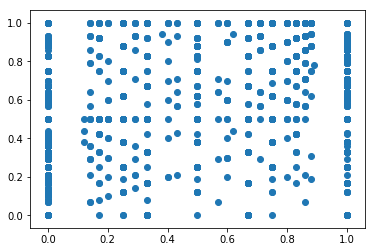

In [53]:
plt.scatter(same_hist,adeq_hist)

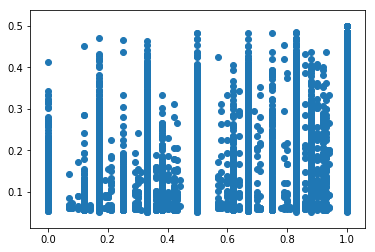

In [54]:
plt.scatter(adeq_hist,resp_hist)

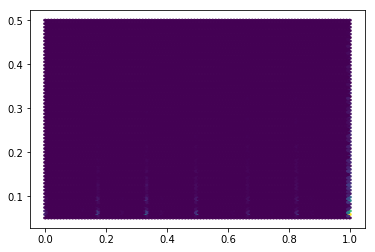

In [56]:
plt.hexbin(adeq_hist,resp_hist)

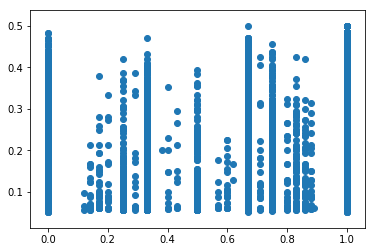

In [55]:
plt.scatter(same_hist,resp_hist)

In [47]:
adeq_hist[:10]

[1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0]

In [48]:
resp_hist[:10]

[0.125,
 0.0625,
 0.0625,
 0.15625,
 0.25,
 0.3142857142857143,
 0.05714285714285714,
 0.11428571428571428,
 0.11428571428571428,
 0.21212121212121213]

In [ ]:
same_hist

In [7]:
adeq_hist;

In [8]:
adeq2same[1][0]

2492.0

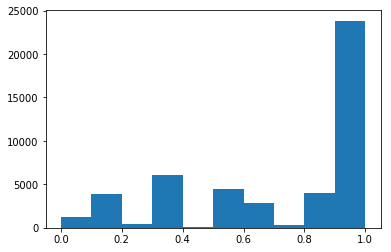

In [9]:
plt.hist(adeq_hist)
plt.savefig("adequacy_histogram.jpg")

In [10]:
plt.savefig("adequacy_histogram.jpg")

<Figure size 432x288 with 0 Axes>

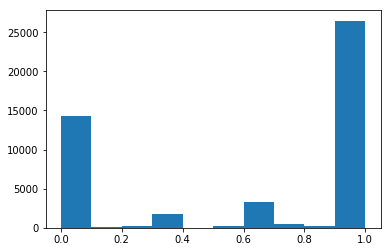

In [11]:
plt.hist(same_hist)
plt.savefig("same_object_histogram.jpg")

In [15]:
same_hist

[1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.67,
 1.0,
 1.0,
 1.0,
 0.0,
 0.67,
 0.0,
 0.67,
 0.0,
 1.0,
 1.0,
 0.33,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.67,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.33,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.43,
 0.43,
 0.71,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.33,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.67,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.67,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.25,
 1.0,
 0.25,
 1.0,
 0.25,
 1.0,
 

In [18]:
error_hist2

Counter({'none/visual': 3406,
         'bounding box/none': 3007,
         'bounding box/none/visual': 232,
         'bounding box/none/other': 17,
         'none/other': 303,
         'none/other/visual': 19,
         'linguistic/none/other/visual': 3,
         'linguistic/none': 301,
         'linguistic/none/visual': 88,
         'linguistic/none/other': 3,
         'bounding box/linguistic/none': 29,
         'bounding box/none/other/visual': 1,
         'bounding box/linguistic/none/visual': 2})

In [26]:
t= sum(error_hist.values())
t2= sum(error_hist2.values())
rows = []

for k in error_hist:
    if not "/" in k:
        rows.append((k,(error_hist[k]/t)*100,\
                   (error_hist2[k]/t2)*100))

commonk = [   ]  
for k,v in error_hist2.most_common(5):
    rows.append((k,(error_hist[k]/t)*100,\
                   (error_hist2[k]/t2)*100))
    commonk.append(k)
    
for k,v in error_hist.most_common(5):
    if "/" in k and k not in commonk:
        rows.append((k,(error_hist[k]/t)*100,\
                   (error_hist2[k]/t2)*100))
    
        

In [27]:
error_hist2

Counter({'none/visual': 3406,
         'bounding box/none': 3007,
         'bounding box/none/visual': 232,
         'bounding box/none/other': 17,
         'none/other': 303,
         'none/other/visual': 19,
         'linguistic/none/other/visual': 3,
         'linguistic/none': 301,
         'linguistic/none/visual': 88,
         'linguistic/none/other': 3,
         'bounding box/linguistic/none': 29,
         'bounding box/none/other/visual': 1,
         'bounding box/linguistic/none/visual': 2})

In [28]:
err_df = pd.DataFrame(rows,columns=['error','%','%'])
err_df

,error,%,%
0,bounding box,46.888795,0.000000
1,visual,2.529711,0.000000
2,other,0.611205,0.000000
3,linguistic,0.152801,0.000000
4,none/visual,16.778438,45.958710
5,bounding box/none,18.370119,40.574821
6,none/other,1.353990,4.088517
7,linguistic/none,1.303056,4.061530
8,bounding box/none/visual,1.901528,3.130482
9,bounding box/visual,2.954160,0.000000


In [37]:
error_hist_so_high

Counter({'none': 23127,
         'none/visual': 3881,
         'linguistic/none/visual': 122,
         'bounding box/none': 2749,
         'other/visual': 216,
         'visual': 581,
         'bounding box/none/visual': 383,
         'linguistic/visual': 79,
         'bounding box/none/other': 42,
         'none/other/visual': 178,
         'none/other': 297,
         'bounding box': 369,
         'linguistic/none/other/visual': 3,
         'bounding box/other': 20,
         'linguistic/none': 298,
         'linguistic/other/visual': 11,
         'bounding box/linguistic/none': 32,
         'linguistic/none/other': 20,
         'bounding box/visual': 251,
         'bounding box/other/visual': 32,
         'linguistic': 36,
         'bounding box/linguistic': 27,
         'bounding box/linguistic/other': 3,
         'linguistic/other': 43,
         'bounding box/none/other/visual': 3,
         'bounding box/linguistic/other/visual': 3,
         'bounding box/linguistic/visual': 8,
    

In [34]:
t= sum(error_hist_so_low.values())
t2= sum(error_hist_so_high.values())
rows = []


commonk = [   ]  
for k,v in error_hist_so_low.most_common(4):
    rows.append((k,(error_hist_so_low[k]/t)*100,\
                   (error_hist_so_high[k]/t2)*100))
    commonk.append(k)
    
for k,v in error_hist_so_high.most_common(5):
    if k not in commonk:
        rows.append((k,
                   (error_hist_so_low[k]/t)*100,\
                   (error_hist_so_high[k]/t2)*100))
    
err_df = pd.DataFrame(rows,columns=['error','%','%'])
err_df     

,error,%,%
0,bounding box,65.844859,0.317710
1,bounding box/none,14.744438,6.144574
2,none,5.466025,74.324457
3,bounding box/visual,3.487673,0.379942
4,none/visual,1.214672,12.285873
5,visual,0.324714,1.775245
6,bounding box/none/visual,0.938064,0.956405


In [155]:
t= sum(error_hist.values())
err1 = Counter({k:(v/t)*100 for (k,v) in error_hist.items() if not "/" in k})
err2 = Counter({k:(v/t)*100 for (k,v) in error_hist.items() if "/" in k})
err_df = pd.DataFrame(list(err1.items())+err2.most_common(8),columns=['error','%'])


In [29]:
err_df.round(1)

,error,%,%
0,bounding box,46.9,0.0
1,visual,2.5,0.0
2,other,0.6,0.0
3,linguistic,0.2,0.0
4,none/visual,16.8,46.0
5,bounding box/none,18.4,40.6
6,none/other,1.4,4.1
7,linguistic/none,1.3,4.1
8,bounding box/none/visual,1.9,3.1
9,bounding box/visual,3.0,0.0


In [35]:
print(err_df.round(1).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                    error &     \% &     \% \\
\midrule
             bounding box &  65.8 &   0.3 \\
        bounding box/none &  14.7 &   6.1 \\
                     none &   5.5 &  74.3 \\
      bounding box/visual &   3.5 &   0.4 \\
              none/visual &   1.2 &  12.3 \\
                   visual &   0.3 &   1.8 \\
 bounding box/none/visual &   0.9 &   1.0 \\
\bottomrule
\end{tabular}



In [28]:
adeq2same

{0: {0: 14138, 1: 2011}, 1: {0: 2492, 1: 28520}}

In [36]:
adeq2same/adeq2same.sum()

array([[0.2997816 , 0.04264117],
       [0.05284027, 0.60473696]])

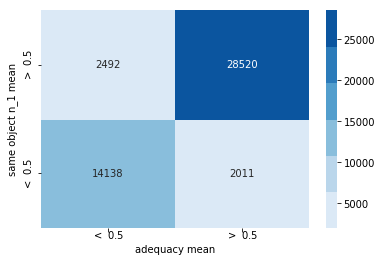

In [68]:
res = sn.heatmap(adeq2same, annot=True, fmt='.0f',cmap=sn.color_palette("Blues"))
res.invert_yaxis()
plt.yticks([0.5,1.5], ['$<$ 0.5', '$>$ 0.5'],va='center')
plt.xticks([0.5,1.5], ['$<$ 0.5', '$>$ 0.5'],va='center')
plt.xlabel('adequacy mean')
plt.ylabel('same object n_1 mean')
plt.savefig("contingency_table.jpg")

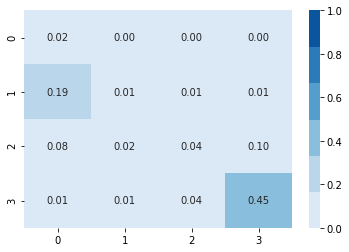

In [54]:
res = sn.heatmap(adeq2same2/adeq2same2.sum(), annot=True, vmin=0.0, vmax=1.0, fmt='.2f', cmap=sn.color_palette("Blues"))

In [51]:
adeq2same2.sum()

47161.0

In [52]:
adeq2same.sum()

47161.0

In [69]:
import spacy

ModuleNotFoundError: No module named 'spacy'

In [95]:
same_obj = np.array(same_hist) == 0
adeq_same_obj = np.array(adeq_hist)[same_obj]

In [96]:
len(adeq_same_obj)

14338

In [97]:
len(adeq_hist)

47161

(array([ 669., 2140.,  187., 3323.,   51., 1970.,  765.,   70.,  803.,
        4360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

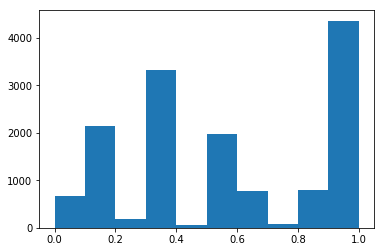

In [98]:
plt.hist(adeq_same_obj)

(array([6.370e+03, 1.400e+01, 4.100e+01, 4.470e+02, 3.000e+00, 4.500e+01,
        6.560e+02, 8.100e+01, 3.700e+01, 4.053e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

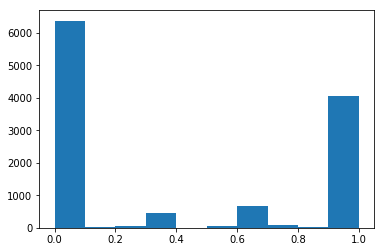

In [101]:
inadeq_obj = np.array(adeq_hist) < 0.5
same_inadeq_obj = np.array(same_hist)[inadeq_obj]
plt.hist(same_inadeq_obj)

In [169]:
newdf = []
for ix,row in df.iterrows():
    resp = eval(row.spellchecked_min2)
    top = resp.most_common(1)[0][0]
    adeq = eval(row.adequacy_mean)
    #adeq = {k:v for (k,v) in adeq.items() if not k == top}
    same = eval(row.same_object)[top]
    #same = {k:v for (k,v) in same.items() if not k == top}
    #print(row.inadequacy_type)
    error = eval(row.inadequacy_type)
    for n in resp:
        if n != top:
            newdf.append((n,resp[n],resp[n]/sum(resp.values()),adeq[n],same[n],\
                          'bounding box' in error[n],\
                         'visual' in error[n],\
                         'linguistic' in error[n] or 'other' in error[n],\
                          False))
        else:
            newdf.append((n,resp[n],resp[n]/sum(resp.values()),adeq[n],same[n],\
                          'bounding box' in error[n],\
                         'visual' in error[n],\
                         'linguistic' in error[n] or 'other' in error[n],\
                          True))
newdf = pd.DataFrame(newdf,columns=['name','resp','resp%','adeq','same','bbox','visual','other','is_top'])

In [153]:
def map_agree(val):
    if val < 0.5:
        return 1-val
    return val

In [154]:
newdf['same_agree'] = newdf['same'].apply(lambda x: map_agree(x))

In [155]:
newdf['adeq_agree'] = newdf['adeq'].apply(lambda x: map_agree(x))

In [137]:
np.sum(newdf.query('same > 0')['resp'])/np.sum(newdf.resp)

0.9438925259801894

In [140]:
np.sum(newdf.query('same > 0.5')['resp'])/np.sum(newdf.resp)

0.9334809803110321

In [141]:
np.sum(newdf.query('same == 1')['resp'])/np.sum(newdf.resp)

0.9130119983450559

In [150]:
dft2 = newdf.query('resp > 2')
np.sum(dft2.query('adeq > 0.5')['resp'])/np.sum(dft2.resp)

0.9482713826137235

In [193]:
resdf = []

for cond in ["same == 0", " same > 0 & same <= 0.5", "same > 0.5 & same < 1", "same == 1"]:
    r = [cond]
    condf = newdf.query(cond)
    r.append(np.sum(condf['resp'])/np.sum(newdf.resp)*100)
    for er in ['bbox','visual','other']:
        q = '%s == True'%er
        r.append(np.sum(condf.query(q)['resp'])/np.sum(condf.resp)*100)
    resdf.append(r)
    

In [194]:
resdf = pd.DataFrame(resdf,columns = ["same-object-mean","% total responses","bbox error", " visual error", "other error"])
resdf.round(1)

,same-object-mean,% total responses,bbox error,visual error,other error
0,same == 0,5.6,92.8,5.0,5.4
1,same > 0 & same <= 0.5,1.0,63.8,21.0,10.9
2,same > 0.5 & same < 1,2.0,26.1,29.8,10.9
3,same == 1,91.3,4.6,3.8,0.7


In [195]:
print(resdf.round(1).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
        same-object-mean &  \% total responses &  bbox error &   visual error &  other error \\
\midrule
               same == 0 &                5.6 &        92.8 &            5.0 &          5.4 \\
  same > 0 \& same <= 0.5 &                1.0 &        63.8 &           21.0 &         10.9 \\
   same > 0.5 \& same < 1 &                2.0 &        26.1 &           29.8 &         10.9 \\
               same == 1 &               91.3 &         4.6 &            3.8 &          0.7 \\
\bottomrule
\end{tabular}



In [142]:
np.sum(newdf.query('adeq > 0.5')['resp'])/np.sum(newdf.resp)

0.9297512716298766

In [143]:
np.sum(newdf.query('adeq == 1')['resp'])/np.sum(newdf.resp)

0.848219718172747

In [ ]:
for t in [0,0.5,0.99]:
    

In [101]:
newdf.corr()

,resp,adeq,same,is_top
resp,1.000000,0.431530,0.433374,0.892456
adeq,0.431530,1.000000,0.831926,0.398805
same,0.433374,0.831926,1.000000,0.430586
is_top,0.892456,0.398805,0.430586,1.000000


(array([ 1225.,  3867.,   410.,  6127.,   118.,  4457.,  2836.,   302.,
         3983., 23836.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

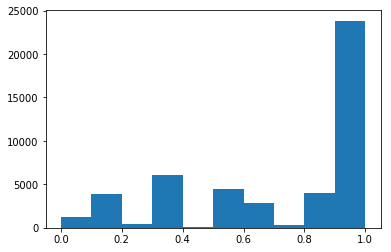

In [104]:
plt.hist(newdf.query("is_top == False").adeq)

In [124]:
resp_hist

[0.125,
 0.0625,
 0.0625,
 0.15625,
 0.25,
 0.3142857142857143,
 0.05714285714285714,
 0.11428571428571428,
 0.11428571428571428,
 0.21212121212121213,
 0.09375,
 0.3125,
 0.0625,
 0.0625,
 0.09375,
 0.058823529411764705,
 0.058823529411764705,
 0.08823529411764706,
 0.3235294117647059,
 0.058823529411764705,
 0.07142857142857142,
 0.2727272727272727,
 0.15151515151515152,
 0.12121212121212122,
 0.18181818181818182,
 0.24242424242424243,
 0.06060606060606061,
 0.0967741935483871,
 0.3225806451612903,
 0.12903225806451613,
 0.125,
 0.125,
 0.08333333333333333,
 0.125,
 0.08333333333333333,
 0.058823529411764705,
 0.17647058823529413,
 0.3225806451612903,
 0.0967741935483871,
 0.06451612903225806,
 0.17142857142857143,
 0.0967741935483871,
 0.16129032258064516,
 0.0967741935483871,
 0.06451612903225806,
 0.06451612903225806,
 0.05714285714285714,
 0.11428571428571428,
 0.08571428571428572,
 0.47058823529411764,
 0.06060606060606061,
 0.09090909090909091,
 0.2777777777777778,
 0.083333333

In [164]:
newdf

,name,resp,resp%,adeq,same,box-error,visual-error,other-error,is_top
0,man,11,0.343750,1.00,1.00,False,False,False,True
1,batter,8,0.250000,1.00,1.00,False,False,False,False
2,player,5,0.156250,1.00,1.00,False,False,False,False
3,person,4,0.125000,1.00,1.00,False,False,False,False
4,baseball player,2,0.062500,1.00,1.00,False,False,False,False
5,helmet,2,0.062500,0.50,0.00,True,False,False,False
6,jacket,14,0.400000,1.00,1.00,False,False,False,True
7,man,11,0.314286,0.50,0.00,True,False,False,False
8,sweatshirt,4,0.114286,1.00,1.00,False,False,False,False
9,hoodie,4,0.114286,1.00,1.00,False,False,False,False


In [162]:
newdf.query("'bounding box' in error")

SystemError: <built-in method view of numpy.ndarray object at 0x1a3044b260> returned a result with an error set